# CSCI 316 - Group Assignment 2

# *Main Features of Pyspark
### • Transformers– functions that convert raw data in some way. 
### • Estimators– if provided with data, result in transformers– algorithms that are used to train models
### • Evaluators– evaluate how a given model performs according to criteria
### • Pipeline– MLlib’s highest-level data type– Transformers, estimators and evaluators are all stages in a pipeline
# * We will actively utilize the four features mentioned above to gain a deep understanding of PySpark.
# -------------------------------------------------------------------------------------------------------

# Note:
## when there is 'str object is not callable' error
## please add 'from pyspark.sql.functions import col'
## sometimes 'col' can't be recognized even though it was imported before

# Load the Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.functions import col
from pyspark.ml import Transformer

from pyspark.sql.types import StringType, DoubleType, IntegerType
import pandas as pd
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import StandardScaler

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Create SparkSession
spark = SparkSession.builder.appName("a2").config("spark.sql.execution.pythonUDF.arrow.enabled", "false").getOrCreate()

# read file
df = spark.read.option("header", "true").csv("train.csv")

# exclude ID and Name --> NOT RELATED TO PREDICT CREDIT SCORE IN COMMON SENSE
selected_columns = [col_name for col_name in df.columns if col_name not in ["ID", "Name"]]
df = df.select(selected_columns)

### The reason for the worse performance after repartitioning  during the data preprocessing stage, is as follows:

### Data Movement Cost: Repartitioning involves physically moving data, incurring additional time and resource consumption. This data movement cost can lead to increased processing time.

### Hence, We will not use repartitioning during data pre-processing

In [ ]:
# Repartition
#num_partitions = 125
#df = df.repartition(num_partitions)

In [2]:
# datatypes are automatically indicated as string
df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SSN: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: string (nullable = true)
 |-- Monthly_Inhand_Salary: string (nullable = true)
 |-- Num_Bank_Accounts: string (nullable = true)
 |-- Num_Credit_Card: string (nullable = true)
 |-- Interest_Rate: string (nullable = true)
 |-- Num_of_Loan: string (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: string (nullable = true)
 |-- Num_of_Delayed_Payment: string (nullable = true)
 |-- Changed_Credit_Limit: string (nullable = true)
 |-- Num_Credit_Inquiries: string (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: string (nullable = true)
 |-- Credit_Utilization_Ratio: string (nullable = true)
 |-- Credit_History_Age: string (nullable = true)
 |-- Payment_of_Min_Amount: string (nullable = true)
 |-- Total_EMI_per_

## Data Labels
### The table, as seen above, contains only four numerical columns. Columns are classified into three categories:

#### label: the label of the data ('Credit_Score') used for classification;
#### categorical_cols: the names of the 7 categorical columns;
#### numeric_cols: the remanining columns.

In [3]:
label = 'Credit_Score'
categorical_cols = ['Customer_ID', 'Month', 'SSN', 'Occupation',
                    'Credit_Mix', 'Type_of_Loan', 'Payment_of_Min_Amount',
                    'Payment_Behaviour']
numeric_cols = list(set(df.columns) - set(categorical_cols) -set([label]))

### Later, we will complete basic data preprocessing tasks and change the data type of all columns to double for smooth model implementation.

# Transformer & Pipeline

In [4]:
# will used at step 6
# This transformer generates predicted values for missing values in specific columns.
class MissingValuePredictor(Transformer):
    """
    Transformer to predict missing values in the target variable using a specified model,
    and fill the missing values in the DataFrame.
    """
    def __init__(self, target_col, join_cols, model):
        """
        Initializes the MissingValuePredictor with target, input, join columns, and model.
        """
        super(MissingValuePredictor, self).__init__()
        self.target_col = target_col
        self.join_cols = join_cols
        self.model = model
        
    def _transform(self, df):
        """
        Fits the specified model on non-missing data,
        predicts missing values, fills them, and returns the DataFrame.
        """
        # Step 3: Predict missing values
        df_missing = df.filter(col(self.target_col).isNull())
        df_missing = df_missing.select(self.join_cols)
        predictions_missing = self.model.transform(df_missing)

        # Step 4: Fill missing values in the original DataFrame
        predicted_df = predictions_missing.select(*(self.join_cols + ["prediction"]))
        df = df.join(predicted_df, on=self.join_cols, how="left_outer")
        df = df.withColumn(self.target_col,
                           when(col(self.target_col).isNull(), col("prediction"))
                           .otherwise(col(self.target_col)))
        df = df.drop("prediction")

        return df
    
class SparkDFPipeline:
    """
    This pipeline is classified into three cases based on the parameter 'case'.

    case = 1:
    Scaling is applied to all columns.

    case = 2:
    Scaling is applied only to continuous variables.

    case = else:
    No scaling is applied.
    """
    
    
    def __init__(self, case=0):
        self.case = case
    
    def fit(self):
        return self
    
    def transform(self, indexed, feature_list, to_remove):
        """
        indexed: dataframe
        feature_list: whole features in the dataframe. will be filtered to be the proper independent vars.
        to_remove: the list of columns that will be removed from feature_list
        """
        # apply scaling to all the vairables
        if self.case == 0:
            # Repartition
            num_partitions = 500
            repartitioned_df = indexed.repartition(num_partitions)

            for col in feature_list:
                if col in to_remove:
                    feature_list.remove(col)

            # Vectorize the df
            assembler = VectorAssembler(inputCols=feature_list, outputCol='features')
            features_vectorized = assembler.transform(repartitioned_df)

            # Standardize the df
            scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
            scaled_data = scaler.fit(features_vectorized)
            preprocessed_data = scaled_data.transform(features_vectorized)
            

        # apply scaling only to continuous variables
        elif self.case == 1:
            # Resample the df
            num_partitions = 500
            repartitioned_df = indexed.repartition(num_partitions)
            
            feature_list = numeric_cols
            for col in feature_list:
                if col in to_remove:
                    feature_list.remove(col)

            # Vectorize the df
            assembler = VectorAssembler(inputCols=feature_list, outputCol='features')
            features_vectorized = assembler.transform(repartitioned_df)

            # Standardize the df
            scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
            scaled_data = scaler.fit(features_vectorized)
            preprocessed_data = scaled_data.transform(features_vectorized)

            preprocessed_data = preprocessed_data.drop('features')
            
            # put back the categorical columns
            input_cols = []
           
            for col in indexed.columns:
                if '_Index' in col:
                    input_cols.append(col)
            
            assembler1 = VectorAssembler(inputCols=input_cols, outputCol="features")
            preprocessed_data = assembler1.transform(preprocessed_data)
            
            
        # No Standardization   
        else:
            # Normal vectorize df
            num_partitions = 500
            repartitioned_df = indexed.repartition(num_partitions)
            for col in feature_list:
                if col in to_remove:
                    feature_list.remove(col)
            assembler = VectorAssembler(inputCols=feature_list, outputCol='features')
            preprocessed_data = assembler.transform(repartitioned_df)


        return preprocessed_data

# Evaluator

In [5]:
# calculate various kind of score for the test set and show the evaluation metrics
def evaluate_model(model, test_data):
    # Make predictions on the validation data
    predictions = model.transform(test_data)

    acc_evaluator = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="accuracy")
    accuracy = acc_evaluator.evaluate(predictions)

    f1_evaluator = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="f1")
    f1_score = f1_evaluator.evaluate(predictions)

    precision_evaluator = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="weightedPrecision")
    precision_score = precision_evaluator.evaluate(predictions)
        
    recall_evaluator = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="weightedRecall")
    recall_score = recall_evaluator.evaluate(predictions)

    # Create a dictionary of model evaluation metrics
    eval_metrics = {
        'Accuracy': accuracy
        , 'F1 Score': f1_score
        , 'Precision': precision_score
        , 'Recall': recall_score
    }
    
    return eval_metrics

# PRE-PROCESSING
### Single Process:
### If the code is used only in a single task or specific process, there is no need to create a Transformer.
### Duplicate Processes:
### Using a Transformer increases code reusability and helps in building pipelines.

## 1. Text Cleaning

In [6]:
# Strip underscore: convert "_" to empty string
for column in df.columns:
    df = df.withColumn(column, regexp_replace(col(column), "_", ""))

# Remove two meaningless string values from the whole data set
strings_to_replace = ["#F%$D@*&8", "!@9#%8"]
for column in df.columns:
    for string_to_replace in strings_to_replace:
        df = df.withColumn(column, regexp_replace(col(column), string_to_replace, ""))

# Since after done with previous work, we got some empty string values
# Hence, we need to convert the empty string to null        
for column in df.columns:
    df = df.withColumn(column, when(df[column]=="", None).otherwise(df[column]))

## 2. Credit _History_Age -> Credic_History_Month
### : Convert to Numerical Var

In [7]:
# Example value of Credit_History_Age: 22 Years and 1 Months
# We'll convert the each value to numeric like 22*12 + 1, which means the total months of credit history

# Divide the each value of "Credit_History_Age" by whitespace
split_age = split(df["Credit_History_Age"], ' ')

# Transform the initial value to total months
total_months = (split_age.getItem(0).cast("int") * 12) + split_age.getItem(3).cast("int")

# Add new column "Credit_History_Month"
df = df.withColumn("Credit_History_Month", when(col("Credit_History_Age").isNotNull(), total_months)
                   .otherwise(col("Credit_History_Age").cast(DoubleType())))

# Remove 'Credit_History_Age'
df = df.drop("Credit_History_Age")

In [8]:
# update numeric_cols
numeric_cols.remove("Credit_History_Age")
numeric_cols.append("Credit_History_Month")

## 3. Convert the data type of all the continuous variables to Double
### Since before training, all the variables should be double
### Later, we'll do the same task for the categorical variables

In [9]:
# If there are missing values in the column, the data type cannot be changed.
# Therefore, if there are missing values, fill them with an arbitrary value of 100000 and then change the data.
# Later, 100000 will be replaced back with missing values.
for column in numeric_cols:
    df = df.withColumn(column, when(df[column].isNull(), lit(100000)).otherwise(df[column]))

# convert all the numeric columns to double
for column in numeric_cols:
    df = df.withColumn(column, df[column].cast(DoubleType()))
    
    
# Replace 100000 back with missing values
for column in numeric_cols:
    df = df.withColumn(column, when(df[column] == 100000, None).otherwise(df[column]))

## 4. Drop Negative values

In [10]:
# alternate negative values to null in the case of columns which cannot be negative.
def drop_negative(df, column):
    df = df.withColumn(column, when(col(column) < 0, None).otherwise(col(column)))
    return df

columns_to_drop_negative = ["Age", "Num_Bank_Accounts", "Num_of_Loan", "Delay_from_due_date", "Num_of_Delayed_Payment",
                            "Monthly_Balance"]

for column in columns_to_drop_negative:
    df = drop_negative(df, column)

## 5. Remove Outliers

In [11]:
# Remove outliers of specific columns
columns_to_remove_outliers = ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
                               'Num_Credit_Inquiries', 'Num_of_Delayed_Payment',
                               'Amount_invested_monthly']

for column in columns_to_remove_outliers:
    # Calculate Q1, Q3, and IQR
    quantiles = df.stat.approxQuantile(column, [0.25, 0.75], 0.01)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Convert outliers to NaN
    df = df.withColumn(column, 
                      when((col(column) < lower_bound) | (col(column) > upper_bound), None).otherwise(col(column)))

###  Total_EMI_per_month

In [12]:
#Group by Customer_ID and check for cases where the value of Total_EMI_per_month does not duplicate.
#If it does not duplicate more than twice, replace it with missing values.

window_spec = Window.partitionBy("Customer_ID").orderBy("Total_EMI_per_month")
df = df.withColumn("count_total_emi", count("Total_EMI_per_month").over(window_spec))

df = df.withColumn("Total_EMI_per_month", \
                   when(col("count_total_emi") <= lit(1), None).otherwise(col("Total_EMI_per_month"))) \
       .drop("count_total_emi")

### Annual_Income

In [13]:
# Adjust the range of Annual_Income
# Removing outliers with IQR deleted some important values.
df = df.withColumn("Annual_Income", when(col("Annual_Income") > 180000, None).otherwise(col("Annual_Income")))

## 6. Deal with Missing values
### - Count Missing Values per Columns

In [14]:
def count_missing_values(df):
    """
    A function to calculate the number and proportion of missing values for each column in the given DataFrame
    """
    result = []
    for column in df.columns:
        missing_count = df.filter(col(column).isNull()).count()
        missing_rate = missing_count / df.count()
        result.append((column, missing_count, missing_rate))
    
    return result

# call the function and print the output
missing_values_result = count_missing_values(df)
for row in missing_values_result:
    print(row)

('Customer_ID', 0, 0.0)
('Month', 0, 0.0)
('Age', 2781, 0.02781)
('SSN', 0, 0.0)
('Occupation', 7062, 0.07062)
('Annual_Income', 999, 0.00999)
('Monthly_Inhand_Salary', 15002, 0.15002)
('Num_Bank_Accounts', 1336, 0.01336)
('Num_Credit_Card', 2271, 0.02271)
('Interest_Rate', 2034, 0.02034)
('Num_of_Loan', 4348, 0.04348)
('Type_of_Loan', 11408, 0.11408)
('Delay_from_due_date', 591, 0.00591)
('Num_of_Delayed_Payment', 8382, 0.08382)
('Changed_Credit_Limit', 2091, 0.02091)
('Num_Credit_Inquiries', 3615, 0.03615)
('Credit_Mix', 20195, 0.20195)
('Outstanding_Debt', 0, 0.0)
('Credit_Utilization_Ratio', 0, 0.0)
('Payment_of_Min_Amount', 0, 0.0)
('Total_EMI_per_month', 114, 0.00114)
('Amount_invested_monthly', 14976, 0.14976)
('Payment_Behaviour', 7600, 0.076)
('Monthly_Balance', 1209, 0.01209)
('Credit_Score', 0, 0.0)
('Credit_History_Month', 9030, 0.0903)


### To fill in missing values in the columns, group by Customer_ID and fill the missing values with the mean or the first value of each group. 
### This is because the dataset contains monthly financial information for each Customer ID.

In [14]:
# Index Customer_ID 
# Since the column will be used to predict other columns' values
indexer = StringIndexer(inputCol="Customer_ID", outputCol="Customer_ID" + "Index")
df = indexer.fit(df).transform(df)

In [15]:
"""
Case 1: Grouping by Customer_ID based on the column to be predicted.
Depending on the type of the column to be predicted (continuous or categorical),
the criteria for filling missing values (group mean or first value) varies.
"""

def fill_missing_with_mean_or_first(df, column_name):
    window_spec = Window().partitionBy("Customer_IDIndex")
    return df.withColumn(column_name, when(col(column_name).isNull(),
                                           first(column_name, ignorenulls=True).over(window_spec)
                                           if column_name in ['Occupation', 'Credit_Mix', 'Payment_Behaviour']
                                           else mean(column_name).over(window_spec))
                                     .otherwise(col(column_name)))

columns_to_fill = ['Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                   'Interest_Rate', 'Num_of_Loan', 'Credit_History_Month', 'Num_Credit_Inquiries', 'Credit_Mix',
                   'Total_EMI_per_month', 'Payment_Behaviour', 'Num_of_Delayed_Payment', 'Delay_from_due_date',
                   'Changed_Credit_Limit']

for column in columns_to_fill:
    df = fill_missing_with_mean_or_first(df, column)

In [16]:
"""
Case 2: Filling Missing values of Type_of_Loan (determined by Customer_ID)
When grouping by Customer ID, if all values in that group are missing, unify them as "Not Specified".
If at least one value exists, fill missing values in that group with the first value of the group.
"""
from pyspark.sql.functions import col

window_spec = Window().partitionBy("Customer_ID")
df = df.withColumn("Type_of_Loan", when(
    count("Type_of_Loan").over(window_spec) == 0, "Not Specified"
).otherwise(
    when(col("Type_of_Loan").isNull(), expr("first(Type_of_Loan, True)").over(window_spec))
    .otherwise(col("Type_of_Loan"))
))

### - Filling missing values using Linear Regression model: Monthly_Balance
### Check the RMSE and Determine whether the model performance is Ok

In [17]:
def train_regression_model(df, feature_cols, target, split_ratio=0.8, seed=100):
    # Feature Vector
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    lr = LinearRegression(featuresCol="features", labelCol=target)

    # Configure Pipeline
    pipeline = Pipeline(stages=[assembler, lr])

    # Split train and test set
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=100)

    # train model
    model = pipeline.fit(train_data)

    # Predict test data set
    predictions = model.transform(test_data)

    # Evaluate
    evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    # returned model will be used for future task (filling missing values)
    return model, rmse


feature_columns = ["Customer_IDIndex", "Annual_Income", "Monthly_Inhand_Salary"]
target_column = "Monthly_Balance"
# Data set without missing values for target column is needed
df_no_missing = df.dropna(subset=[target_column])

# train data and print the RMSE out
model1, rmse1 = train_regression_model(df_no_missing, feature_columns, target_column)
print("RMSE of :", rmse1)

RMSE of : 151.23850172017958


Let's examine if the model is acceptable.

An RMSE of 151 implies an error of approximately 12 between the predicted and actual values, which seems to be an acceptable level of error.

Therefore, we proceed with the missing value handling task using this model.

### Filling missing values with the model

In [18]:
# Define the target variable, input variables, and join columns
target_variable = "Monthly_Balance"
join_columns = ["Customer_IDIndex", "Month", "Annual_Income", "Monthly_Inhand_Salary"]


# Create an instance of the MissingValuePredictor with the specified model
missing_value_predictor = MissingValuePredictor(target_col=target_variable,
                                                join_cols=join_columns,
                                                model=model1)

# Apply the transformation
df = missing_value_predictor.transform(df)

### - Filling missing values using specific prediction model: Amount_invested_monthly
### Check the RMSE and Determine whether the model performance is Ok

In [19]:
feature_columns = ["Customer_IDIndex", "Annual_Income", "Monthly_Inhand_Salary"]
target_column = "Amount_invested_monthly"
# Data set without missing values for target column is needed
df_no_missing = df.dropna(subset=[target_column])

# train data and print the RMSE out
model2, rmse2 = train_regression_model(df_no_missing, feature_columns, target_column)
print("RMSE of :", rmse2)

RMSE of : 95.787619699179


Let's examine if the model is acceptable.

An RMSE of 95 implies an error of approximately 9~10 between the predicted and actual values, which seems to be an acceptable level of error.

Therefore, we proceed with the missing value handling task using this model.

### Filling missing values with the model

In [20]:
# Define the target variable, input variables, and join columns
target_variable = "Amount_invested_monthly"
join_columns = ["Customer_IDIndex", "Month", "Annual_Income", "Monthly_Inhand_Salary"]


# Create an instance of the MissingValuePredictor with the specified model
missing_value_predictor = MissingValuePredictor(target_col=target_variable,
                                                join_cols=join_columns,
                                                model=model2)

# Apply the transformation
df = missing_value_predictor.transform(df)

### - After filling all the missing values

In [21]:
# check whether the number of rows is maintained
df.count()

100000

In [27]:
# Now, there must not be any missing values

missing_values_result = count_missing_values(df)
for row in missing_values_result:
    print(row)

('Customer_IDIndex', 0, 0.0)
('Month', 0, 0.0)
('Annual_Income', 0, 0.0)
('Monthly_Inhand_Salary', 0, 0.0)
('Customer_ID', 0, 0.0)
('Age', 0, 0.0)
('SSN', 0, 0.0)
('Occupation', 0, 0.0)
('Num_Bank_Accounts', 0, 0.0)
('Num_Credit_Card', 0, 0.0)
('Interest_Rate', 0, 0.0)
('Num_of_Loan', 0, 0.0)
('Type_of_Loan', 0, 0.0)
('Delay_from_due_date', 0, 0.0)
('Num_of_Delayed_Payment', 0, 0.0)
('Changed_Credit_Limit', 0, 0.0)
('Num_Credit_Inquiries', 0, 0.0)
('Credit_Mix', 0, 0.0)
('Outstanding_Debt', 0, 0.0)
('Credit_Utilization_Ratio', 0, 0.0)
('Payment_of_Min_Amount', 0, 0.0)
('Total_EMI_per_month', 0, 0.0)
('Amount_invested_monthly', 0, 0.0)
('Payment_Behaviour', 0, 0.0)
('Monthly_Balance', 0, 0.0)
('Credit_Score', 0, 0.0)
('Credit_History_Month', 0, 0.0)


## Encoding: Categorical --> Numeric

In [22]:
# Month mapping: Since the column is ordinal
month_mapping = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12    
}

# Iterate over the month_mapping and update the "Month" column in df
for month_name, numeric_value in month_mapping.items():
    df = df.withColumn("Month", when(df["Month"] == month_name, numeric_value).otherwise(df["Month"]))

In [23]:
# update categorical_cols
categorical_cols = ['SSN', 'Occupation',
                    'Credit_Mix', 'Type_of_Loan', 'Payment_of_Min_Amount',
                    'Payment_Behaviour']

#Add indexed categorical columns to the original DataFrame df.
#The name of the new DataFrame with the applied changes is indexed.

indexed = df
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_Index")
    indexed = indexer.fit(indexed).transform(indexed)

In [24]:
# Target Encoding
# Credit_Score --> Target
indexer = StringIndexer(inputCol="Credit_Score", outputCol="Target")
indexed = indexer.fit(indexed).transform(indexed)
indexed.select('Target').distinct().show()

+------+
|Target|
+------+
|   0.0|
|   1.0|
|   2.0|
+------+



# Convert all to double

### In PySpark, unlike Scikit-Learn, it is necessary to convert the data type of all variables to Double Type as independent variables before the implementation stage of the model.

In [25]:
# categorical
for col in categorical_cols:
    indexed = indexed.withColumn(col, indexed[col].cast(DoubleType()))
# Month
indexed = indexed.withColumn("Month", indexed["Month"].cast(DoubleType()))
# Rename the column
indexed = indexed.withColumnRenamed("Month", "Month_Index")

In [26]:
# remove the columns which are not indexed (original categorical columns)
exclude = ['Customer_ID', 'SSN', 'Occupation', 'Credit_Mix', 'Type_of_Loan',
                  'Payment_of_Min_Amount','Payment_Behaviour', 'Credit_Score', 'Amount_invested_monthly']

selected_cols = [col for col in indexed.columns if col not in exclude]
indexed = indexed.select(selected_cols)

# update numeric_cols
numeric_cols.remove("Amount_invested_monthly")

In [27]:
#### check the data types
indexed.printSchema()

root
 |-- Customer_IDIndex: double (nullable = false)
 |-- Month_Index: double (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Num_Bank_Accounts: double (nullable = true)
 |-- Num_Credit_Card: double (nullable = true)
 |-- Interest_Rate: double (nullable = true)
 |-- Num_of_Loan: double (nullable = true)
 |-- Delay_from_due_date: double (nullable = true)
 |-- Num_of_Delayed_Payment: double (nullable = true)
 |-- Changed_Credit_Limit: double (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Outstanding_Debt: double (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Total_EMI_per_month: double (nullable = true)
 |-- Monthly_Balance: double (nullable = true)
 |-- Credit_History_Month: double (nullable = true)
 |-- SSN_Index: double (nullable = false)
 |-- Occupation_Index: double (nullable = false)
 |-- Credit_Mix_Index: double (n

# Visualization

## Distribution of classes of label (Credit_Score)

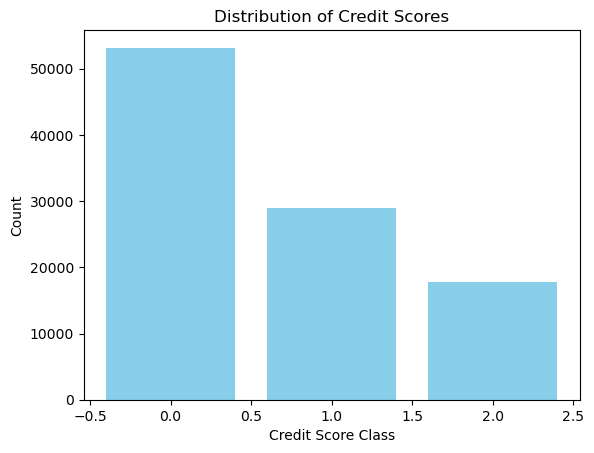

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# count per class
counts = indexed.groupBy("Target").count().orderBy("Target").collect()

# visualization
credit_scores = [row["Target"] for row in counts]
counts = [row["count"] for row in counts]

plt.bar(credit_scores, counts, color='skyblue')
plt.xlabel('Credit Score Class')
plt.ylabel('Count')
plt.title('Distribution of Credit Scores')
plt.show()

In [29]:
indexed.groupBy("Target").count().show()

+------+-----+
|Target|count|
+------+-----+
|   0.0|53174|
|   1.0|28998|
|   2.0|17828|
+------+-----+



### From the visualization and table above, it can be observed that the classes of the target variable ("Credit_Score") are imbalanced. Such imbalance can lead to reduced accuracy in model implementation.

## Data distribution of the rest

In [ ]:
"""
from pylab import rcParams

df_pd = df.toPandas()
rcParams["figure.figsize"]=(20,22)
df.hist()
plt.grid()
"""

### Please refer to the visualization.ipynb for this code block
# toPandas() method doesn't work due to the PySpark version

# User-Defined Transformer: Create New Feature

### This is a process of creating a new feature.
### The new feature is obtained through the ratio of two existing columns.
### The following formula is used to generate the feature:
### inputCol1 / (inputCol2 + epsilon)
## The transformer below includes a parameter that determines whether to apply the new feature to the DataFrame, i.e., it determines if it's a variable to be used in Preciction Model.

In [28]:
from pyspark.ml import Transformer
from pyspark.ml.param.shared import Param, Params
from pyspark.sql import DataFrame
from pyspark.sql.functions import col


# When 'useNewFeature' is True, new feature will be added to the data frame
class NewFeatureTransformer(Transformer, Params):
    """
    Transformer to add a new feature to the DataFrame.
    """
    def __init__(self, inputCol1, inputCol2, outputCol, useNewFeature = True):
        """
        Initializes the NewFeatureTransformer with input and output column names
        and a flag indicating whether to use the new feature or not.
        """
        super(NewFeatureTransformer, self).__init__()
        self.inputCol1 = inputCol1
        self.inputCol2 = inputCol2
        self.outputCol = outputCol
        self.useNewFeature = Param(self, "useNewFeature", "Flag to indicate whether to use the new feature or not")
        self.useNewFeature.default = True
        self.setUseNewFeature(useNewFeature)

    def setUseNewFeature(self, value: bool):
        """
        Sets the flag indicating whether to use the new feature or not.
        """
        self._paramMap[self.useNewFeature] = value
        return self

    def getUseNewFeature(self):
        """
        Gets the flag indicating whether to use the new feature or not.
        """
        return self.getOrDefault(self.useNewFeature)

    def _transform(self, df) -> DataFrame:
        """
        Adds a new feature to the DataFrame based on the specified input columns,
        and returns the DataFrame with or without the new feature based on the flag.
        """
        if self.getUseNewFeature():
            epsilon = 1e-4  # To avoid division by zero
            # Add a new feature based on the input column
            df = df.withColumn(self.outputCol, col(self.inputCol1) / (col(self.inputCol2)+epsilon))
        else:
            # Drop the output column if not using the new feature
            df = df.drop(self.outputCol)
        return df

In [29]:
# 1st New Feature: Financial_Stability
new_feature_transformer = NewFeatureTransformer(inputCol1="Monthly_Inhand_Salary",
                                                inputCol2="Monthly_Balance",
                                                outputCol="Financial_Stability", useNewFeature=True)
indexed = new_feature_transformer.transform(indexed)

# 2nd New Feature: Loan_Replacement_Capacity
new_feature_transformer = NewFeatureTransformer(inputCol1="Total_EMI_per_month",
                                                inputCol2="Monthly_Inhand_Salary",
                                                outputCol="Loan_Replacement_Capacity", useNewFeature=True)
indexed = new_feature_transformer.transform(indexed)

# 3rd New Feature: Income_To_Debt_Ratio
new_feature_transformer = NewFeatureTransformer(inputCol1="Annual_Income",
                                                inputCol2="Outstanding_Debt",
                                                outputCol="Income_To_Debt_Ratio", useNewFeature=True)
indexed = new_feature_transformer.transform(indexed)

### In this case, we added all the new features to the dataframe 'indexed'.
### But we can just select specific features to use among three by adjusting the value of parameter 'useNewFeature'.

In [30]:
# You can see that 3 new features are added to dataframe indexed
indexed.printSchema()

root
 |-- Customer_IDIndex: double (nullable = false)
 |-- Month_Index: double (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Num_Bank_Accounts: double (nullable = true)
 |-- Num_Credit_Card: double (nullable = true)
 |-- Interest_Rate: double (nullable = true)
 |-- Num_of_Loan: double (nullable = true)
 |-- Delay_from_due_date: double (nullable = true)
 |-- Num_of_Delayed_Payment: double (nullable = true)
 |-- Changed_Credit_Limit: double (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Outstanding_Debt: double (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Total_EMI_per_month: double (nullable = true)
 |-- Monthly_Balance: double (nullable = true)
 |-- Credit_History_Month: double (nullable = true)
 |-- SSN_Index: double (nullable = false)
 |-- Occupation_Index: double (nullable = false)
 |-- Credit_Mix_Index: double (n

In [33]:
indexed.count()

100000

In [35]:
# check the missing values after adding new features
missing_values_result = count_missing_values(indexed)
for row in missing_values_result:
    print(row)

('Customer_IDIndex', 0, 0.0)
('Month_Index', 0, 0.0)
('Annual_Income', 0, 0.0)
('Monthly_Inhand_Salary', 0, 0.0)
('Age', 0, 0.0)
('Num_Bank_Accounts', 0, 0.0)
('Num_Credit_Card', 0, 0.0)
('Interest_Rate', 0, 0.0)
('Num_of_Loan', 0, 0.0)
('Delay_from_due_date', 0, 0.0)
('Num_of_Delayed_Payment', 0, 0.0)
('Changed_Credit_Limit', 0, 0.0)
('Num_Credit_Inquiries', 0, 0.0)
('Outstanding_Debt', 0, 0.0)
('Credit_Utilization_Ratio', 0, 0.0)
('Total_EMI_per_month', 0, 0.0)
('Monthly_Balance', 0, 0.0)
('Credit_History_Month', 0, 0.0)
('SSN_Index', 0, 0.0)
('Occupation_Index', 0, 0.0)
('Credit_Mix_Index', 0, 0.0)
('Type_of_Loan_Index', 0, 0.0)
('Payment_of_Min_Amount_Index', 0, 0.0)
('Payment_Behaviour_Index', 0, 0.0)
('Target', 0, 0.0)
('Financial_Stability', 0, 0.0)
('Loan_Replacement_Capacity', 0, 0.0)
('Income_To_Debt_Ratio', 0, 0.0)


In [31]:
# update numeric_cols
numeric_cols.append("Financial_Stability")
numeric_cols.append("Loan_Replacement_Capacity")
numeric_cols.append("Income_To_Debt_Ratio")

# Feature Engineering

### Feature engineering was conducted based on the insights of banking professionals and background knowledge.

#### Customer_ID
#### : The overall dataset consists of monthly financial information for each customer. Since most columns are associated with Customer_ID, it is adopted as an input variable.

#### Month
#### : The overall dataset consists of monthly financial information for each customer. Therefore, it is adopted as an independent variable.

#### Annual_Income
#### : Annual_Income is a factor that influences credit rating classification. Therefore, it is adopted as an independent variable.

#### Monthly_Inhand_Salary
#### : Monthly_Inhand_Salary is a factor that influences credit rating classification. However, since it holds almost identical informational value to Annual_Income, it is excluded from the independent variables.

#### SSN
#### : SSN includes customer's residency information. In some banks, this information is used in credit rating decisions.

#### Occupation
#### : Customer's occupation information is a significant factor affecting credit ratings. Therefore, it is adopted as an independent variable.

#### Age
#### : Age is a factor that influences credit rating classification. Therefore, it is adopted as an independent variable.

#### Interest_Rate, Num_of_Loan, Delay_from_due_date, Num_of_Delayed_Payment, Outstanding_Debt
#### : These pieces of information are crucial factors in credit rating decisions.

#### Additionally, the remaining columns also have an impact on credit rating decisions and thus can be adopted as independent variables.

#### Changed_Credit_Limit, Num_Credit_Inquiries, Credit_Utilization_Ratio, Total_EMI_per_month, Monthly_Balance,  Credit_History_Month, Credit_Mix, Type_of_Loan, Payment_of_Min_Amount, Payment_Behaviour

### In conclusion, except for ID and Name, most columns have been selected as independent variables for predicting Credit_Score. Concerns about overfitting due to the curse of dimensionality will be addressed by comparing the accuracy difference between training and test sets after executing the actual model. Consideration of the relationship between independent variables has generally been excluded as multicollinearity has minimal impact in classification problems.


# Pipeline: Scale + Feature Engineering + Repartitioning
### Repartitioning in PySpark refers to the process of splitting data into multiple partitions. Each partition enables parallel processing in a distributed environment. Repartitioning is particularly important when dealing with large-scale datasets as each partition can be processed independently in a distributed environment, thereby improving processing speed. Additionally, adjusting the number of partitions allows for optimization of cluster resource utilization.

In [32]:
# Feature Engineering
# We can modify the list 'to_remove' as the task of Feature Engineering
feature_list = indexed.columns
to_remove = ['Monthly_Inhand_Salary', 'Target']

# SparkDFPipleline is defined at the beginning
pipeline = SparkDFPipeline(case=0)
preprocessed_data  = pipeline.transform(indexed, feature_list, to_remove)

# Stratified Sampling (8:2)

In [33]:
# Calculate fractions for each stratum
fractions = preprocessed_data.groupBy('Target').count().withColumn('fraction',
                                                                   F.lit(0.8)).select('Target', 'fraction').collect()

# Convert the result to a dictionary
fractions_dict = {row['Target']: row['fraction'] for row in fractions}

# Perform stratified sampling using sampleBy
df_train = preprocessed_data.sampleBy('Target', fractions_dict, seed=100)
df_test = preprocessed_data.subtract(df_train)

# Model Implementation
# : Random Forest, Decision Tree, Logistic Regression(Multinomial)


## Random Forest

### Default Model

In [34]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Target", featuresCol="scaled_features", numTrees=10)
rf_model = rf.fit(df_train)
prediction = rf_model.transform(df_train)

Eval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("Target")
print(f'training accuracy: {Eval.evaluate(prediction)}')

prediction_test = rf_model.transform(df_test)
Eval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("Target")
print(f'test accuracy: {Eval.evaluate(prediction_test)}')

training accuracy: 0.6662706204584964
test accuracy: 0.6700593723494487


In [ ]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="Target", featuresCol="scaled_features", numTrees=10)
rf_model = rf.fit(df_train)

evaluation_results_RF = evaluate_model(rf_model, df_test)

print("Evaluation Results:")
print(f"{'Metric':<20}{'RF Model':<20}")
print("=" * 60)

for metric in evaluation_results_RF.keys():
    default_value = evaluation_results_RF[metric]
    print(f"{metric:<20}{default_value:<20.6f}")

### Fine Tunning (Hyper parameter tunning)

In [ ]:
# Create a Pipeline with RandomForest as the estimator
pipeline = Pipeline(stages=[rf])


# Define the parameter grid
param_grid = ParamGridBuilder() \
            .addGrid(rf.numTrees, [10, 20, 30]) \
            .addGrid(rf.maxDepth, [5, 6, 8, 10]) \
            .
            .build()

# Define the cross-validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="accuracy"),
                          numFolds=5)

# Fit the pipeline with cross-validation to find the best model
cv_model = crossval.fit(df_train)

# Get the best model from cross-validation
best_rf_model = cv_model.bestModel

# Make predictions on the test set using the best model
predictions_test = best_rf_model.transform(df_test)

# Evaluate the predictions on the test set
test_accuracy = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="accuracy").evaluate(predictions_test)
print(f"Test Accuracy: {test_accuracy}")

# Get the best parameters
best_numTrees = best_rf_model.getOrDefault('numTrees')
best_maxDepth = best_rf_model.getOrDefault('maxDepth')

# Print the best parameters
print("Best numTrees:", best_numTrees)
print("Best maxDepth:", best_maxDepth)

### Evaluate

In [ ]:
evaluation_results_RF = evaluate_model(best_rf_model, df_test)

print("Evaluation Results:")
print(f"{'Metric':<20}{'RF Model':<20}")
print("=" * 60)

for metric in evaluation_results_RF.keys():
    default_value = evaluation_results_RF[metric]
    print(f"{metric:<20}{default_value:<20.6f}")

## Decision Tree -------------------------------------------------------------------------------------------

### Default Model

In [ ]:
# Define the DecisionTree model
dt = DecisionTreeClassifier(labelCol="Target", featuresCol="scaled_features")

# Train the DecisionTree model
dt_model = dt.fit(df_train)

evaluation_results_DT = evaluate_model(dt_model, df_test)

print("Evaluation Results:")
print(f"{'Metric':<20}{'DT Model':<20}")
print("=" * 60)

for metric in evaluation_results_DT.keys():
    default_value = evaluation_results_DT[metric]
    print(f"{metric:<20}{default_value:<20.6f}")

## Important:
## We obtained the best parameters through fine-tuning code blocks previously, but after restarting the kernel, the output disappeared. 
## Since it takes over 3 hours to execute the code block and obtain the output, we proceeded to run the evaluator based on the previously obtained best parameters.
### Best maxDepth:  15
### Best maxBins:  60
### Best minInstancesPerNode:  1
### Best minInfoGain:  0.0

In [ ]:
# Define the model with the best parameters
best_dt = DecisionTreeClassifier(labelCol="Target", featuresCol="scaled_features",
                                 maxDepth=15, maxBins=60, minInstancesPerNode=1, minInfoGain=0.0)
evaluation_results_DT = evaluate_model(best_dt, df_test)

print("Evaluation Results:")
print(f"{'Metric':<20}{'DT Model':<20}")
print("=" * 60)

for metric in evaluation_results_DT.keys():
    default_value = evaluation_results_DT[metric]
    print(f"{metric:<20}{default_value:<20.6f}")

### Fine Tunning (Hyper parameter tunning)

In [ ]:
# Create a pipeline with the defined stages
pipeline = Pipeline(stages=[dt])

# Create a grid of parameters to search over
param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15, 20]) \
    .addGrid(dt.maxBins, [20, 32, 40, 60, 80]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
    .addGrid(dt.minInfoGain, [0.0, 0.1, 0.2]) \
    .build()

# Set up the evaluator for multi-class classification
evaluator = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="accuracy")

# Create a cross-validator
cross_validator = CrossValidator(estimator=dt,
                                estimatorParamMaps=param_grid,
                                evaluator=evaluator,
                                numFolds=5)  # You can adjust the number of folds as needed

# Fit the cross-validator to the training data
cv_model = cross_validator.fit(df_train)

# Get the best model from the cross-validation
best_dt_model = cv_model.bestModel

# Make predictions on the test set using the best model
prediction_test_dt = best_dt_model.transform(df_test)

# Evaluate the test accuracy using the best model
test_accuracy_dt = evaluator.evaluate(prediction_test_dt)
print(f'Test accuracy (Decision Tree): {test_accuracy_dt}')

# Print the best parameters
print("Best maxDepth: ", best_dt_model._java_obj.getMaxDepth())
print("Best maxBins: ", best_dt_model._java_obj.getMaxBins())
print("Best minInstancesPerNode: ", best_dt_model._java_obj.getMinInstancesPerNode())
print("Best minInfoGain: ", best_dt_model._java_obj.getMinInfoGain())

### Evaluate

In [ ]:
evaluation_results_DT = evaluate_model(best_dt_model, df_test)

print("Evaluation Results:")
print(f"{'Metric':<20}{'DT Model':<20}")
print("=" * 60)

for metric in evaluation_results_DT.keys():
    default_value = evaluation_results_DT[metric]
    print(f"{metric:<20}{default_value:<20.6f}")

# Logistic Regression

### Default Model

In [35]:
# Define the Logistic Regression model for multi-class classification
lr = LogisticRegression(labelCol="Target", featuresCol="scaled_features", maxIter=10, family="multinomial")

# Train the Logistic Regression model
lr_model = lr.fit(df_train)

# Make predictions on the training set
prediction_train_lr = lr_model.transform(df_train)

# Evaluate the training accuracy for multi-class classification
multiEval_train_lr = MulticlassClassificationEvaluator().setMetricName("accuracy") \
    .setPredictionCol("prediction").setLabelCol("Target")
training_accuracy_lr = multiEval_train_lr.evaluate(prediction_train_lr)
print(f'Training accuracy (Logistic Regression): {training_accuracy_lr}')

# Make predictions on the test set
prediction_test_lr = lr_model.transform(df_test)

# Evaluate the test accuracy for multi-class classification
multiEval_test_lr = MulticlassClassificationEvaluator().setMetricName("accuracy") \
    .setPredictionCol("prediction").setLabelCol("Target")
test_accuracy_lr = multiEval_test_lr.evaluate(prediction_test_lr)
print(f'Test accuracy (Logistic Regression): {test_accuracy_lr}')

Training accuracy (Logistic Regression): 0.6466975999599784
Test accuracy (Logistic Regression): 0.6528463802823928


### Fine Tunning (Hyper parameter tunning)

In [ ]:
# Create a pipeline with the defined stages
pipeline = Pipeline(stages=[lr])

# Create a grid of parameters to search over
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.maxIter, [10, 100, 1000]) \
    .build()

# Set up the evaluator for multi-class classification
evaluator = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="accuracy")

# Create a cross-validator
cross_validator = CrossValidator(estimator=pipeline,
                                estimatorParamMaps=param_grid,
                                evaluator=evaluator,
                                numFolds=5)  # You can adjust the number of folds as needed

# Fit the cross-validator to the training data
cv_model = cross_validator.fit(df_train)

# Get the best model from the cross-validation
best_lr_model = cv_model.bestModel.stages[0]

# Make predictions on the test set using the best model
prediction_test_lr = best_lr_model.transform(df_test)

# Evaluate the test accuracy using the best model
test_accuracy_lr = evaluator.evaluate(prediction_test_lr)
print(f'Test accuracy (Logistic Regression): {test_accuracy_lr}')

# Print the best parameters
print("Best regParam: ", best_lr_model.getRegParam())
print("Best maxIter: ", best_lr_model.getMaxIter())

### Evaluate

In [ ]:
evaluation_results_LR = evaluate_model(best_lr_model, df_test)

print("Evaluation Results:")
print(f"{'Metric':<20}{'LR Model':<20}")
print("=" * 60)

for metric in evaluation_results_LR.keys():
    default_value = evaluation_results_LR[metric]
    print(f"{metric:<20}{default_value:<20.6f}")

# ---------------------------------------------Report---------------------------------------------------

# Curse of Demiensionality?
## It appears that there is no overfitting observed as the accuracy on the test set is slightly higher than that on the training set for all models. This suggests that the curse of dimensionality has been avoided.

# Comparison among Models


최종 

# Comparison between Spark MLlib and Scikit-Learn (e.g., their pros/cons or similarity/difference). 


### Spark MLlib is designed for big data processing and can efficiently handle large datasets distributed across multiple nodes in a cluster. It leverages the power of distributed computing, making it suitable for parallel processing tasks, which can lead to faster training times. However, setting up and configuring a Spark cluster is complex, especially for users unfamiliar with distributed computing concepts. While Spark MLlib provides a wide range of machine-learning algorithms, it does not offer the same breadth and depth of algorithms as Scikit-Learn, which has been developed for a longer time.

### On the other hand, Scikit-Learn has a user-friendly and intuitive API, making it easy for beginners to get started with machine learning tasks. However, its algorithms may consume a significant amount of memory, especially when dealing with large datasets, which can be a limitation for machines with limited resources.


# Conclusion

### SMOTE sampling and the Min-Max scaler applied in the previous assignment are determined to improve model accuracy.But these can't be easily implemented in PySpark. It posed challenges being limited to PySpark and not attempting any conversions from pandas data to PySpark. Without implementing  SMOTE and Min-Max scaler (but used Standard Scaler in this assignment), we got relatively low accuracy.
### Even though these challenges, we maximized the use of PySpark by implementing everything solely using it, starting from the preprocessing stage. This ensured that we focused on the main theme of this task, which is maximizing the utilization of PySpark.